In [0]:
from fastai import *
from fastai.vision import *
import numpy as np

In [3]:
URLs.CAMVID_TINY

'http://files.fast.ai/data/examples/camvid_tiny'

In [12]:
path = Path('data')
path.ls()

[PosixPath('data/camvid_tiny')]

In [8]:
untar_data(URLs.CAMVID_TINY, dest=path)

PosixPath('data/camvid_tiny')

In [0]:
path_images = path/'camvid_tiny/images'
path_labels = path/'camvid_tiny/labels'

In [16]:
images = get_image_files(path_images)
images[:4]

[PosixPath('data/camvid_tiny/images/0016E5_08340.png'),
 PosixPath('data/camvid_tiny/images/Seq05VD_f03960.png'),
 PosixPath('data/camvid_tiny/images/0016E5_08101.png'),
 PosixPath('data/camvid_tiny/images/0016E5_06810.png')]

In [32]:
path_labels.ls()[:4]

[PosixPath('data/camvid_tiny/labels/Seq05VD_f03150_P.png'),
 PosixPath('data/camvid_tiny/labels/Seq05VD_f01830_P.png'),
 PosixPath('data/camvid_tiny/labels/0006R0_f03630_P.png'),
 PosixPath('data/camvid_tiny/labels/0016E5_07973_P.png')]

In [0]:
a = images[0]

In [34]:
a.stem

'0016E5_08340'

In [35]:
a.suffix

'.png'

In [0]:
get_y_func = lambda x: path/'camvid_tiny/labels'/ (x.stem + '_P' + x.suffix)

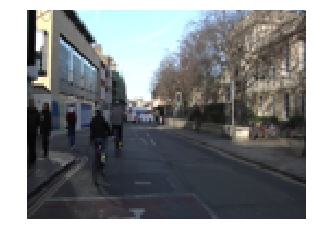

In [40]:
im_file = images[2]

img = open_image(im_file)
img.show(figsize=(5,5))

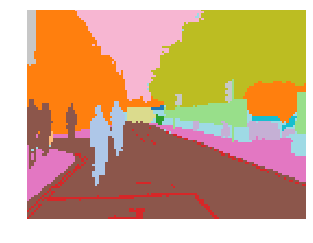

In [41]:
mask = open_mask(path_labels/get_y_func(im_file))
mask.show(figsize=(5,5), alpha=1)

In [45]:
codes = np.loadtxt(path/'camvid_tiny/codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [47]:
sl = SegmentationItemList.from_folder(path/'camvid_tiny/images')
sl

SegmentationItemList (100 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
Path: data/camvid_tiny/images

In [49]:
sl_s = sl.split_by_rand_pct(0.2)
sl_s

ItemLists;

Train: SegmentationItemList (80 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
Path: data/camvid_tiny/images;

Valid: SegmentationItemList (20 items)
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
Path: data/camvid_tiny/images;

Test: None

In [58]:
ll = sl_s.label_from_func(get_y_func,classes=codes)
ll

LabelLists;

Train: LabelList (80 items)
x: SegmentationItemList
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
y: SegmentationLabelList
ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128)
Path: data/camvid_tiny/images;

Valid: LabelList (20 items)
x: SegmentationItemList
Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128),Image (3, 96, 128)
y: SegmentationLabelList
ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128),ImageSegment (1, 96, 128)
Path: data/camvid_tiny/images;

Test: None

In [0]:
t_ll = ll.transform(tfms=get_transforms(), tfm_y=True, size = (128,96))

In [0]:
data = t_ll.databunch()

In [0]:
data = data.normalize(imagenet_stats)

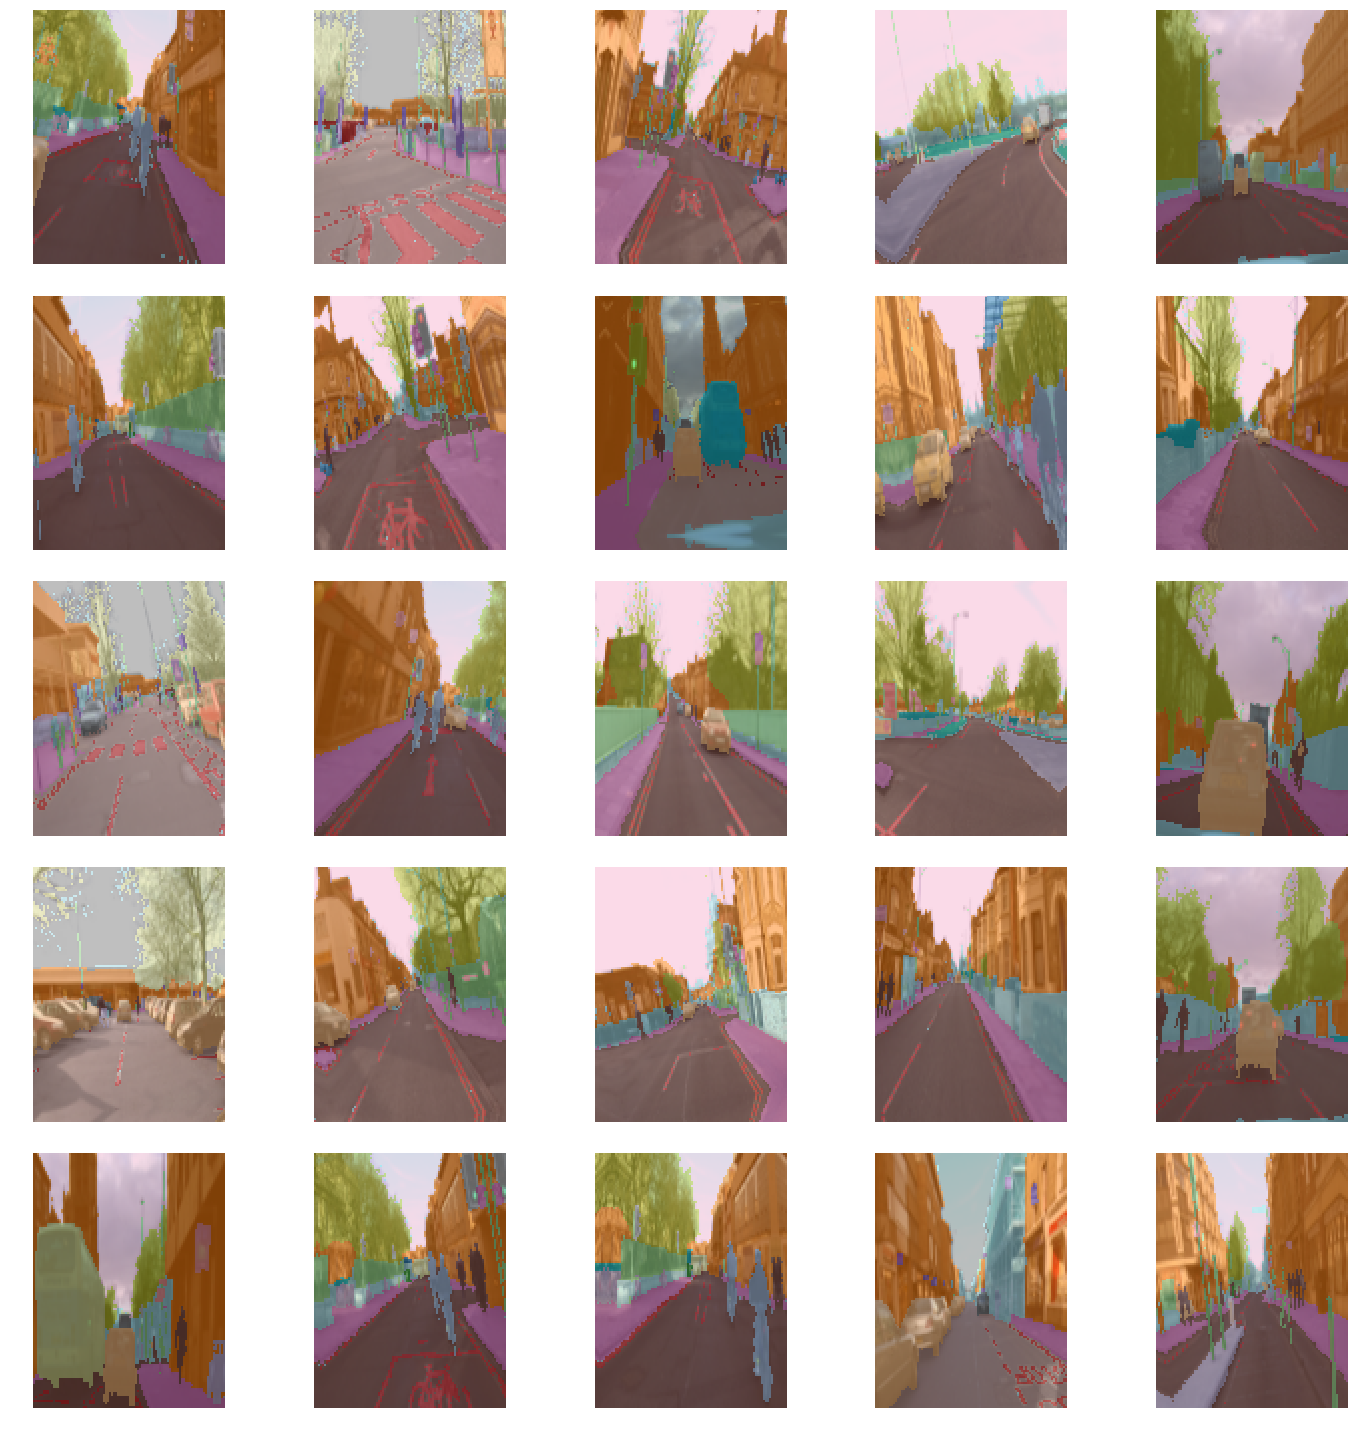

In [67]:
data.show_batch()

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[acc_camvid])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


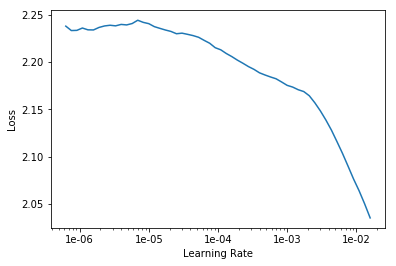

In [79]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#todo implement yourself
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [77]:

learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,acc_camvid,time
0,4.588562,3.523869,0.050649,00:02
1,4.092507,536.728882,0.248831,00:02
2,97.932053,3.516692,0.160317,00:02
3,73.712189,3.211971,0.330495,00:02
4,59.070530,3.191118,0.356650,00:02


In [78]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,acc_camvid,time
0,3.305292,3.178229,0.366021,00:02
1,3.291665,3.122469,0.405017,00:02
2,3.265279,2.964447,0.400373,00:02
3,3.195669,2.670778,0.416707,00:02
4,3.070130,4.873759,0.327159,00:02
5,3.504239,2.230157,0.288155,00:02
6,3.303040,2.189931,0.342026,00:02
7,3.174537,2.173715,0.345459,00:02
8,3.067479,2.157257,0.344363,00:02
9,2.977899,2.151106,0.344526,00:02


In [80]:
learn.fit_one_cycle(10,1e-5)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.231151,2.148469,0.345359,00:02
1,2.223926,2.145739,0.346245,00:02
2,2.224221,2.142915,0.347233,00:02
3,2.230295,2.140423,0.348409,00:02
4,2.241707,2.137741,0.349279,00:02
5,2.243323,2.135474,0.350153,00:02
6,2.242350,2.133085,0.350876,00:02
7,2.239757,2.131071,0.351456,00:02
8,2.238585,2.129596,0.352158,00:02
9,2.237322,2.128107,0.352763,00:02


In [82]:
learn.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.158398,2.159726,0.450438,00:02
1,2.150347,2.155205,0.450362,00:02
2,2.150783,2.147278,0.450665,00:02
3,2.152217,2.133048,0.451950,00:02
4,2.153165,2.115800,0.454405,00:02
5,2.152184,2.098739,0.457249,00:02
6,2.151166,2.084607,0.459779,00:02
7,2.145246,2.073704,0.461720,00:02
8,2.140203,2.067112,0.462666,00:02
9,2.133619,2.063356,0.463145,00:02


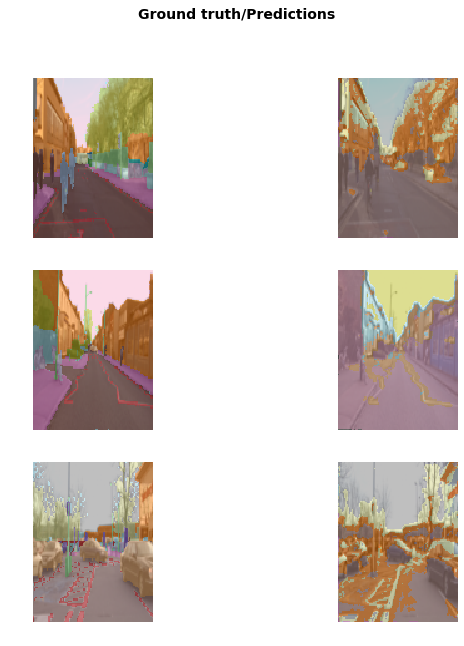

In [83]:
learn.show_results(rows=3, figsize=(10,10))